In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skl2onnx import to_onnx
from onnxruntime import InferenceSession
%matplotlib inline

In [181]:
# Load the data
data_path = "filled_data.csv"
data = pd.read_csv(data_path)

# Extract the relevant columns
datetime_column = pd.to_datetime(data['datetime'])
# Get all feature columns except 'datetime'
feature_columns = data.columns[1:]  # Exclude the 'datetime' column



In [183]:
def build_training_data(hourly_data_path):
    """Build training data from hourly data function. Skips NaN'd days."""

    hourly_data = pd.read_csv(hourly_data_path)
    
    print('Loaded hourly data')

    # integrated power consumption

    dec = [] # daily energy consumption
    t_dec = []

    time = pd.to_datetime(hourly_data['datetime']).dt.strftime('%Y-%m-%dT%H:%M:%S').values.astype('datetime64[s]')

    
    power_consumption = hourly_data['kw_total_zone2'].values

    for ti, t in enumerate(time):
        tmp_t = pd.Timestamp(t)

        if np.isclose(tmp_t.hour, 0) and np.isclose(tmp_t.minute, 0):

            day_end = np.datetime64(tmp_t + pd.Timedelta(days=1))
            ind = np.where((tmp_t < time) & (time < day_end), True, False)

            if len(time[ind]) > 0 and not np.isnan(power_consumption[ind]).any():
                t_dec.append(np.datetime64(tmp_t).astype('datetime64[s]'))
                dec.append(np.trapz(power_consumption[ind], time[ind].astype(int))/3600) # integrated kW to kJ then to kWh

    # time series of daily energy consumption
    t_dec = np.array(t_dec)
    dec = np.array(dec)

    print('Calculated daily energy consumption')

    # seperating predictors

    N = 7 # N days of predictors beforehand
    final_ind = []
    final_hourly = []

    predictor_window = pd.Timedelta(days=N)

    for ti, t in enumerate(t_dec):
        tmp_t = pd.Timestamp(t)
        ind = np.where((tmp_t - predictor_window <= time) & (time < tmp_t), True, False) # finding indices within the N prior days

        bad_ind = np.isnan(hourly_data.iloc[ind, 1::].values)
        if len(time[ind]) >= 24 * N and not bad_ind.any(): # rejecting any data with NaNs; useful for the student dataset
            final_ind.append(ti)
            final_hourly.append(hourly_data.iloc[ind, 1::].values) # dropping datetime column

    # getting targets and predictors
    target_time = t_dec[final_ind]
    targets = dec[final_ind]
    predictors = np.array(final_hourly)

    print('Calculated predictor window')

    return target_time, targets, predictors


In [184]:
data.shape

(17520, 28)

In [185]:
target_time, target, predictors = build_training_data('filled_data.csv')
print(target.shape)
print(predictors.shape)

Loaded hourly data
Calculated daily energy consumption
Calculated predictor window
(723,)
(723, 168, 27)


In [186]:
# Exclude the first column (datetime)
input_data = data.iloc[:, 1:]

# Calculate the number of days (excluding the first week)
num_days = 730 - 7  # 730 days with the first 7 days skipped

# Initialize the 3D array
targets = np.zeros((num_days, 24, input_data.shape[1]))

# Iterate through each day and extract the data
for day in range(num_days):
    start_index = day * 24 + 7 * 24
    end_index = start_index + 24
    targets[day, :, :] = input_data.iloc[start_index:end_index, :]

targets = targets[:, :, 22]




In [187]:
target.shape

(723,)

In [188]:
from sklearn.preprocessing import MinMaxScaler

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape the array to (723 * 168, 27) to apply MinMaxScaler
reshaped_predictors = predictors.reshape(-1, 27)

# Fit and transform the data
scaled_predictors = scaler.fit_transform(reshaped_predictors)

# Reshape the scaled data back to the original shape
predictors = scaled_predictors.reshape(predictors.shape)


reshaped_target = target.reshape(-1, 1)
targets = scaler.fit_transform(targets)
# target = scaler.fit_transform(reshaped_target)

print(predictors.shape)
print(targets.shape)


(723, 168, 27)
(723, 24)


In [189]:
target

array([ 45.964 ,  57.7505, 111.2795,  96.0515, 101.8965,  99.7285,
        94.511 ,  57.508 , 114.774 ,  93.792 ,  93.4475, 112.281 ,
       115.297 , 118.8145,  73.7635,  86.311 , 136.9215, 153.8915,
       133.4875, 135.096 , 117.304 ,  84.843 ,  83.3405, 131.4165,
       114.0025, 106.866 , 111.908 , 120.7865,  87.6235,  80.3305,
       128.498 , 112.137 , 103.4025, 112.5355,  42.042 ,  84.628 ,
        83.502 , 120.259 , 123.7475,  95.3705,  99.6945, 100.811 ,
        85.2775,  72.92  , 129.1965, 117.6265, 100.132 ,  46.6155,
         0.    ,   0.    ,   0.    ,   0.    ,  69.1785, 113.221 ,
       121.546 , 119.482 ,  96.725 , 100.513 , 133.441 , 137.3975,
       128.049 , 106.4715, 104.6025,  77.    ,  79.916 , 136.4105,
       113.67  , 115.5505, 117.4545, 108.7525,  77.9595,  88.5905,
        90.288 ,  94.1555,  93.595 ,  95.823 ,  80.916 ,  69.3975,
        72.165 , 102.893 , 100.64  ,  99.65  , 146.777 , 168.554 ,
        94.037 ,  96.7305, 134.1015, 104.7505, 115.0815,  76.5

In [239]:
from sklearn.model_selection import train_test_split

# split_index = int(len(targets) * 0.8)

# # Split the vectors into training and testing sets
# train_y, test_y = target[:split_index], target[split_index:]
# train_X, test_X = predictors[:split_index], predictors[split_index:]

train_X, test_X, train_y, test_y, indices_train, indices_test = train_test_split(predictors, targets, np.arange(len(targets)), test_size=0.2, random_state=55)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(578, 168, 27) (578, 24) (145, 168, 27) (145, 24)


In [240]:
len(indices_test)

145

In [ ]:
# import tensorflow as tf

# def relative_squared_error(y_true, y_pred):
#     """Relative squared error."""
#     y_true_np = tf.keras.backend.eval(y_true)
#     y_pred_np = tf.keras.backend.eval(y_pred)

#     return np.mean((y_pred_np - y_true_np)**2) / np.mean((y_true_np - np.mean(y_true_np))**2)

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchmetrics.regression import RelativeSquaredError

In [ ]:
# relative_squared_error = RelativeSquaredError()

In [ ]:
# # Define the PyTorch model
# class MyModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(MyModel, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out = self.fc(out[:, -1, :])  # Take the output from the last time step
#         return out

In [ ]:
# # Convert data to PyTorch tensors
# train_X_torch, train_y_torch = torch.Tensor(train_X), torch.Tensor(train_y)
# test_X_torch, test_y_torch = torch.Tensor(test_X), torch.Tensor(test_y)

In [ ]:
# # Initialize model, loss function, and optimizer
# input_size = train_X_torch.shape[2]
# hidden_size = 7
# output_size = 1
# model = MyModel(input_size, hidden_size, output_size)
# criterion = relative_squared_error  
# optimizer = optim.Adam(model.parameters(), lr=0.000001)

In [ ]:
# from torch.utils.data import TensorDataset, DataLoader

# # Create DataLoader for training and testing
# train_dataset = TensorDataset(train_X_torch, train_y_torch)
# train_loader = DataLoader(train_dataset, batch_size=36, shuffle=True)

# test_dataset = TensorDataset(test_X_torch, test_y_torch)
# test_loader = DataLoader(test_dataset, batch_size=36, shuffle=False)

In [ ]:
# # Training loop
# num_epochs = 50
# for epoch in range(num_epochs):
#     model.train()
#     for inputs, targets in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets.unsqueeze(1))
#         loss.backward()
#         optimizer.step()

#     # Validation
#     model.eval()
#     with torch.no_grad():
#         for inputs, targets in test_loader:
#             outputs = model(inputs)
#             val_loss = criterion(outputs, targets.unsqueeze(1))

#     print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

In [241]:
def relative_squared_error(y_pred, y_true):
    """Relative squared error (RSE; also called relative mean square error). < 1 is good, = 1 is bad, > 1 really bad."""
    return K.mean((y_pred - y_true)**2)/K.mean((y_true - K.mean(y_true))**2)

In [242]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [243]:
[x.shape for x in [train_X, train_y, test_X, test_y]]

[(578, 168, 27), (578, 24), (145, 168, 27), (145, 24)]

In [279]:


# Design Lambda
int_layer = Lambda(lambda x: K.sum(x, axis=1))

# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(64))
model.add(Dense(24))
# model.add(Dense(1))
# model.add(int_layer)
model.compile(loss='mse', optimizer='adam')
# fit network


history = model.fit(train_X, train_y, epochs=75, batch_size=18, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/75
33/33 - 5s - loss: 0.0387 - val_loss: 0.0202 - 5s/epoch - 141ms/step
Epoch 2/75
33/33 - 2s - loss: 0.0178 - val_loss: 0.0159 - 2s/epoch - 51ms/step
Epoch 3/75
33/33 - 2s - loss: 0.0157 - val_loss: 0.0150 - 2s/epoch - 65ms/step
Epoch 4/75
33/33 - 2s - loss: 0.0147 - val_loss: 0.0143 - 2s/epoch - 75ms/step
Epoch 5/75
33/33 - 2s - loss: 0.0140 - val_loss: 0.0142 - 2s/epoch - 63ms/step
Epoch 6/75
33/33 - 2s - loss: 0.0135 - val_loss: 0.0143 - 2s/epoch - 66ms/step
Epoch 7/75
33/33 - 2s - loss: 0.0131 - val_loss: 0.0143 - 2s/epoch - 63ms/step
Epoch 8/75
33/33 - 2s - loss: 0.0128 - val_loss: 0.0143 - 2s/epoch - 63ms/step
Epoch 9/75
33/33 - 2s - loss: 0.0125 - val_loss: 0.0142 - 2s/epoch - 64ms/step
Epoch 10/75
33/33 - 2s - loss: 0.0124 - val_loss: 0.0141 - 2s/epoch - 63ms/step
Epoch 11/75
33/33 - 2s - loss: 0.0122 - val_loss: 0.0141 - 2s/epoch - 64ms/step
Epoch 12/75
33/33 - 2s - loss: 0.0121 - val_loss: 0.0141 - 2s/epoch - 63ms/step
Epoch 13/75
33/33 - 2s - loss: 0.0120 - val_loss

In [280]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 100)               51200     
                                                                 
 dense_24 (Dense)            (None, 64)                6464      
                                                                 
 dense_25 (Dense)            (None, 24)                1560      
                                                                 
Total params: 59224 (231.34 KB)
Trainable params: 59224 (231.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


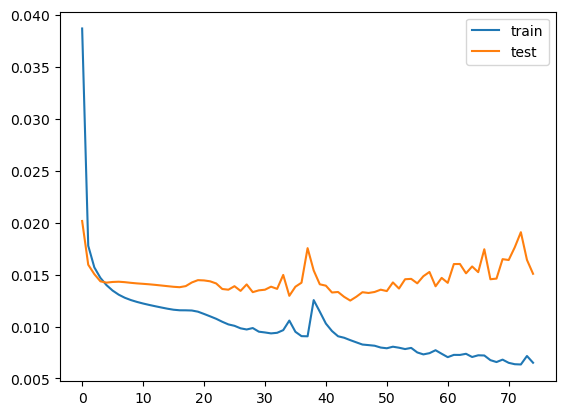

In [281]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [282]:
# make a prediction
yhat = model.predict(predictors)
yhat.shape

23/23 [==============================] - 1s 24ms/step


(723, 24)

In [283]:
yhat_test = model.predict(test_X)
yhat_test.shape

5/5 [==============================] - 0s 43ms/step


(145, 24)

In [284]:
yhat_train = model.predict(train_X)
yhat_train.shape

19/19 [==============================] - 1s 34ms/step


(578, 24)

In [285]:
train_target = target[indices_train]
train_target.shape

(578,)

In [286]:
test_target = target[indices_test]
test_target.shape

(145,)

In [287]:
inv_yhat = scaler.inverse_transform(yhat)
inv_yhat.shape

(723, 24)

In [288]:
inv_yhat_train = scaler.inverse_transform(yhat_train)
inv_yhat_train.shape

(578, 24)

In [271]:
inv_yhat_test = scaler.inverse_transform(yhat_test)
inv_yhat_test.shape

(145, 24)

In [289]:
predicted_kw_zone2 = np.trapz(inv_yhat, axis=1)
predicted_kw_zone2.shape

(723,)

In [290]:
predicted_kw_zone2_train = np.trapz(inv_yhat_train, axis=1)
predicted_kw_zone2_train.shape

(578,)

In [291]:
predicted_kw_zone2_test = np.trapz(inv_yhat_test, axis=1)
predicted_kw_zone2_test.shape

(145,)

In [292]:
for i in range (len(predicted_kw_zone2)):
  print(predicted_kw_zone2[i], target[i])

60.152374 45.964000000000006
72.140625 57.75049999999999
121.92116 111.27949999999998
90.21314 96.05150000000002
96.259964 101.8965
93.13804 99.7285
91.08599 94.511
63.201412 57.508
101.73908 114.774
96.703156 93.792
84.98334 93.44750000000002
101.542404 112.281
102.64657 115.29699999999998
95.37987 118.81450000000002
62.91078 73.7635
108.970345 86.311
113.3227 136.92149999999998
140.40009 153.89149999999998
119.56389 133.4875
117.24556 135.09600000000003
118.43265 117.304
79.23659 84.843
84.120834 83.34049999999999
138.8029 131.41649999999998
116.9105 114.0025
62.56754 106.86600000000001
96.06616 111.908
106.14706 120.7865
68.36503 87.6235
89.49048 80.33050000000001
147.64804 128.498
106.78413 112.13699999999999
88.77856 103.40249999999999
84.93739 112.53550000000001
94.67518 42.04200000000001
80.290436 84.628
90.519005 83.50200000000001
124.95636 120.25899999999999
118.65787 123.74749999999999
84.74916 95.37050000000004
101.835045 99.69449999999999
101.09938 100.811
72.935104 85.2775

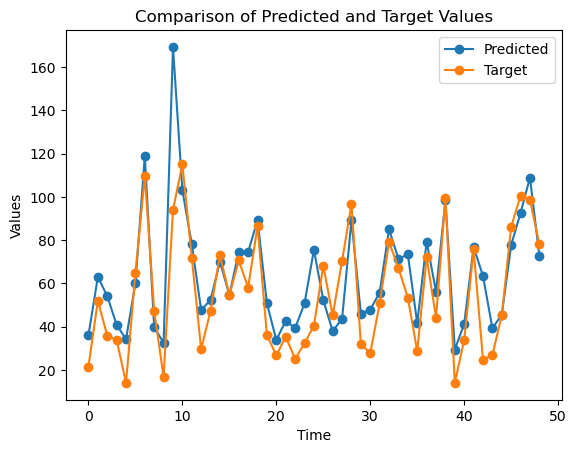

In [298]:
# Plotting
plt.plot(predicted_kw_zone2_test[::3], 'o-', label='Predicted')
plt.plot(test_target[::3], 'o-', label='Target')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Comparison of Predicted and Target Values')
plt.legend()
plt.show()

In [300]:
def relative_squared_error(y_pred, y_true):
    """Relative squared error (RSE; also called relative mean square error). < 1 is good, = 1 is bad, > 1 really bad."""
    return np.mean((y_pred - y_true)**2)/np.mean((y_true - y_true.mean())**2)

print(relative_squared_error(predicted_kw_zone2_train, train_target))

0.07188877724423355
